In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, json
from glob import glob
import numpy as np

import keras

from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19


from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from keras import models
from tensorflow.python.keras.models import Model,load_model,Sequential

from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.python.keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint, Callback

from keras.preprocessing.image import load_img, img_to_array

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Using TensorFlow backend.


Found GPU at: /device:GPU:0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
target_image_path = '/content/drive/My Drive/Colab Notebooks/img/changjiang6.jpg'
style_reference_image_path = '/content/drive/My Drive/Colab Notebooks/img/shanshui2.jpg'
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

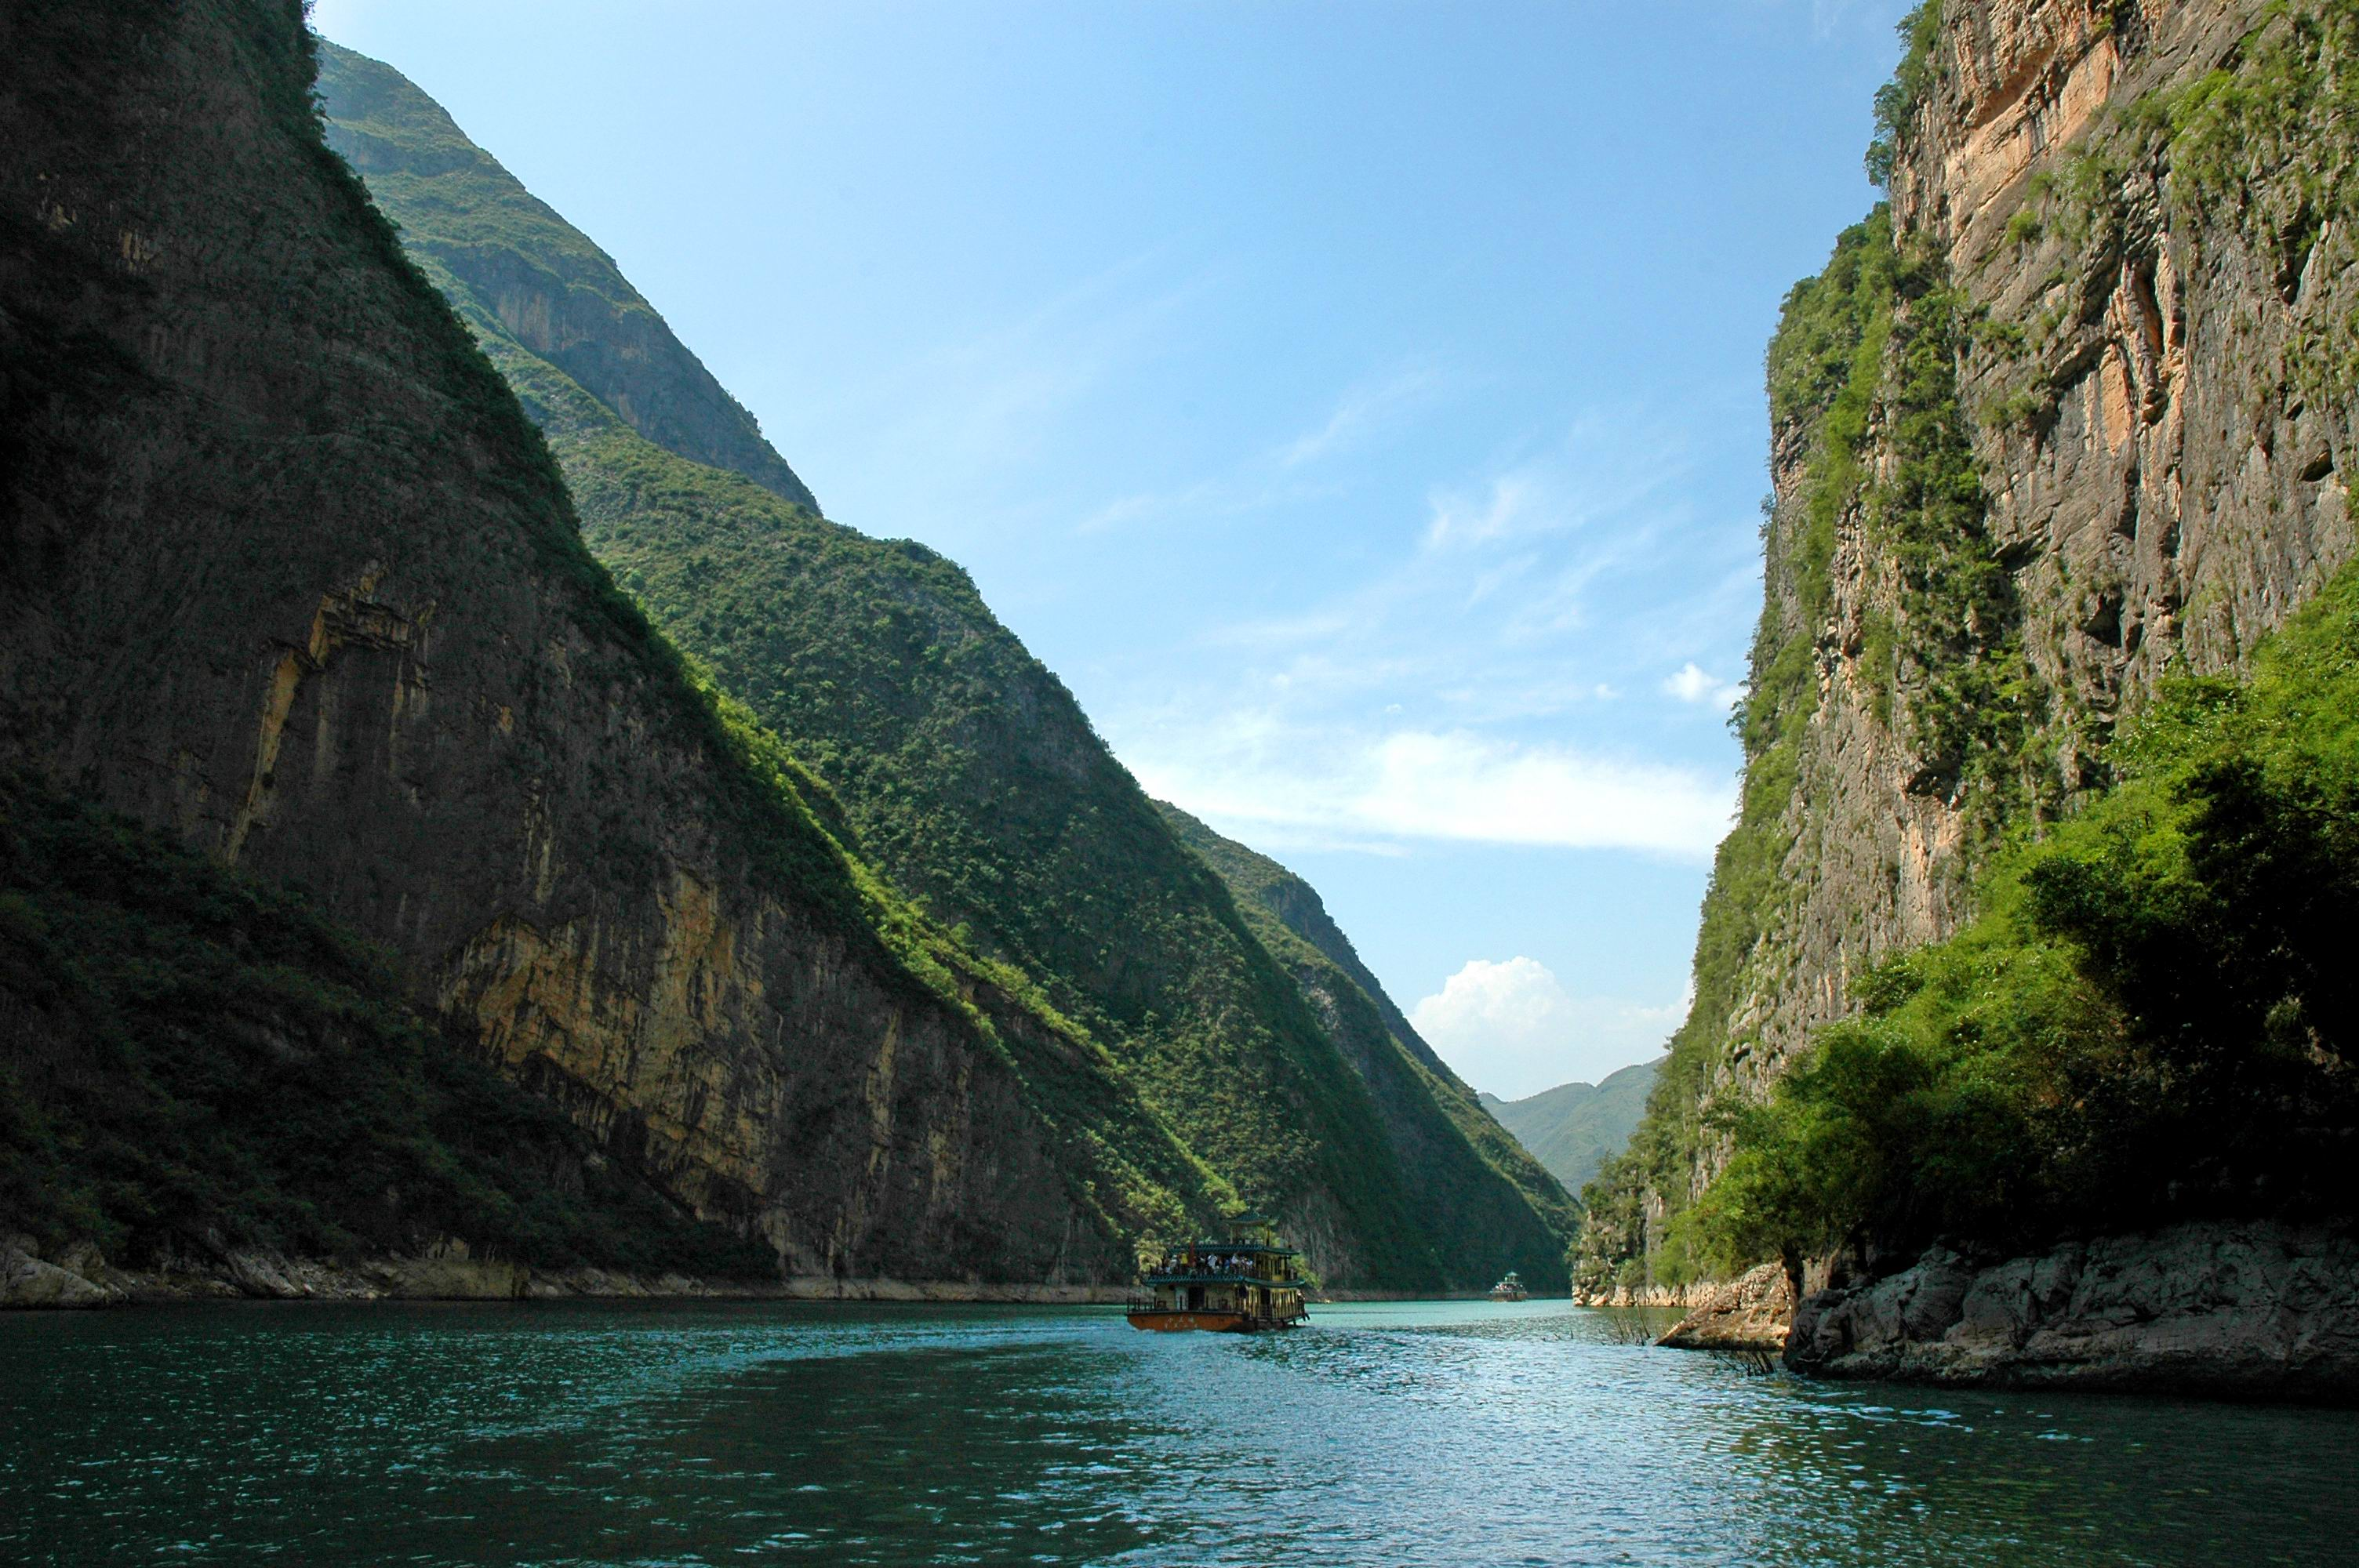

In [0]:
from IPython.display import Image

Image(target_image_path)

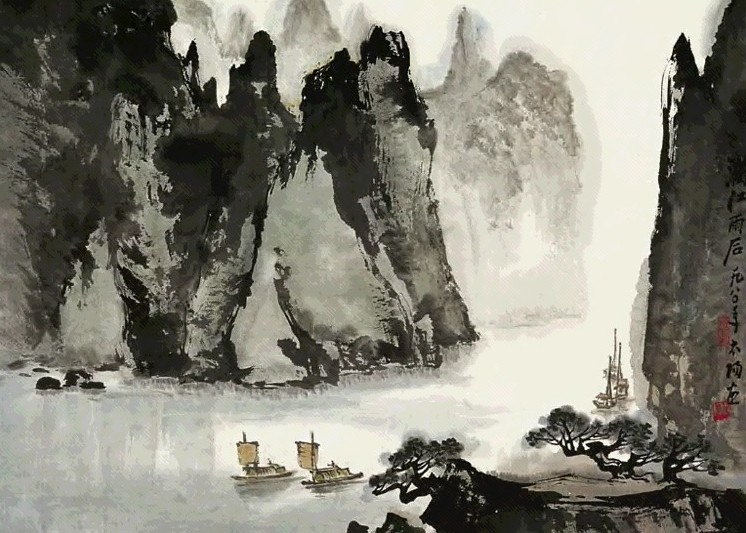

In [0]:
Image(style_reference_image_path)

In [0]:
from keras.applications import vgg19
def preprocess_image(image_path, path = True):
  if path:
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
  else:
    img = img_to_array(image_path)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return img

def deprocess_image(x):
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [0]:
model = load_model('/content/drive/My Drive/Colab Notebooks/vgg19_6_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 601, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 601, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 601, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 300, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 150, 128)     0     

In [0]:
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
                'conv2d_1',
                'conv2d_3']

content_layers = 'block4_conv2'

In [0]:
style_output = [layer.output for layer in model.layers if layer.name in style_layers]
content_output = [layer.output for layer in model.layers if layer.name in content_layers]

In [0]:
style_img = preprocess_image(style_reference_image_path)
content_img = preprocess_image(target_image_path)

In [0]:
style_model = tf.keras.models.Model(inputs=model.input, outputs=style_output)
content_model = tf.keras.models.Model(inputs=model.input, outputs=content_output)

In [0]:
activations_s = style_model.predict(style_img, steps=1) 
activations_c = content_model.predict(content_img, steps=1) 

InvalidArgumentError: ignored

In [0]:
for i in activations_s:
  print(i.shape)
print('\n')
for i in activations_c:
  print(i.shape)

(1, 400, 601, 64)
(1, 200, 300, 128)
(1, 100, 150, 256)
(1, 50, 75, 512)
(1, 25, 37, 512)


(50, 75, 512)


In [0]:
layer_names = []
for layer in content_output:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations_c): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size1 = layer_activation.shape[0] #The feature map has shape (1, size, size, n_features).
    size2 = layer_activation.shape[1]
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size1 * n_cols, images_per_row * size2))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[:,:,col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size1 : (col + 1) * size1, # Displays the grid
                         row * size2 : (row + 1) *size2] = channel_image
    scale = 1. / size1
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')


Output hidden; open in https://colab.research.google.com to view.

In [0]:
layer_names = []
for layer in style_output:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations_s): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size1 = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    size2 = layer_activation.shape[2]
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size1 * n_cols, images_per_row * size2))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size1 : (col + 1) * size1, # Displays the grid
                         row * size2 : (row + 1) *size2] = channel_image
    scale = 1. / size1
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')


Output hidden; open in https://colab.research.google.com to view.